# Notebook for evaluating trained CNNs
- Load trained LCU
- Select folder with eval data (idea is that test = patched and predict = not patched). So incorporate both ways.
- Create DL with same label mappings as original. 
- Predict those, figure out way to show images of memory-mapped images (ie predict set)
- Or just stick with test set up for now? 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
sys.path.append('scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch, torchvision, torchsummary
import pytorch_lightning as pl
# import segmentation_models_pytorch as smp

In [103]:
# LCU = lcm.load_model(filename='scripts/LCU_2022-11-17-1659.data')
LCU = lcm.load_model(filename='scripts/LCU_2022-11-18-0537.data')
LCU.eval()

# ## From https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing_basic.html#save-a-checkpoint

# ## LightningModule from checkpoint
# ## To load a LightningModule along with its weights and hyperparameters use the following method:

# model = LCU.load_from_checkpoint("/path/to/checkpoint.ckpt")


LandCoverUNet class

In [26]:
dir_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/gradbach_6tiles/12.5cm Aerial Photo/117383-1_RGB_1_Shape/images/'
dir_mask_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/gradbach_6tiles/12.5cm Aerial Photo/117383-1_RGB_1_Shape/masks/'
path_mapping_dict = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__main_categories__2022-11-17-1512.pkl'

n_classes = 7
# n_classes = LCU.n_classes
assert n_classes == 7
test_ds = lcm.DataSetPatches(im_dir=dir_im_patches, mask_dir=dir_mask_patches, 
                            preprocessing_func=LCU.preprocessing_func, path_mapping_dict=path_mapping_dict,
                            subsample_patches=False, frac_subsample=1)
assert test_ds.n_classes == n_classes
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=4, num_workers=16)

Patches ordered randomly
Loaded label_mapping_dict__main_categories__2022-11-17-1512.pkl to map labels


In [92]:
tmp_class_name_list =['NO CLASS',
 'Wood and Forest Land',
 'Moor and Heath Land',
 'Agro-Pastoral Land',
 'Water and Wetland',
 'Rock and Coastal Land',
 'Developed Land']

(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>


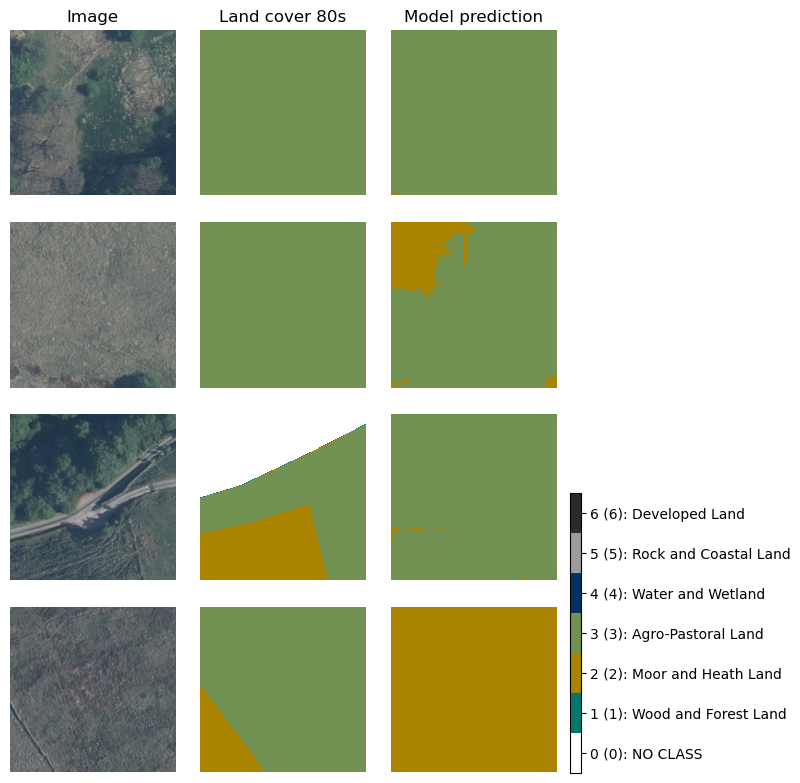

In [111]:
kk += 4
tmp_batch = lcm.get_batch_from_ds(ds=test_ds, batch_size=4, start_ind=kk)
_ = lcm.predict_single_batch_from_testdl_or_batch(model=LCU, 
                                         batch=tmp_batch,
                                        #  test_dl=test_dl, 
                                         preprocessing_fun=test_ds.preprocessing_func,
                                         lc_class_name_list=tmp_class_name_list, unique_labels_array=np.arange(7))

In [27]:
trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)  # run on GPU; and set max_epochs.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
## Predict the labels of unseen data => use test data for now so we can compare performance to (LC 80s) 'ground truth'
pred_test = trainer.predict(LCU, test_dl)  # returns list of tensors (one tensor for each batch)
pred_test = lca.concat_list_of_batches(pred_test)  # concatenate batches
## LCU outputs a softmax (ie 1 probability for each class) => get argmax for visual comparison
pred_test = lca.change_tensor_to_max_class_prediction(pred=pred_test)

In [8]:
# all_ims = lca.concat_list_of_batches([test_ds[x][0][None, :, :, :] for x in range(1350)])
# all_masks = lca.concat_list_of_batches([torch.Tensor(test_ds[x][1][None, :, :]) for x in range(1350)])

In [9]:
# dict_mapping = pickle.load(open(path_mapping_dict, 'rb'))           
# mapping_label_to_new_dict = dict_mapping['dict_label_mapping']
# unique_labels_arr = np.array(list(dict_mapping['dict_label_mapping'].keys()))
# class_name_list = list(dict_mapping['dict_new_names'].values())
# n_classes = len(class_name_list)

In [10]:
class_name_list

['NO CLASS',
 'Wood and Forest Land',
 'Moor and Heath Land',
 'Agro-Pastoral Land',
 'Water and Wetland',
 'Rock and Coastal Land',
 'Developed Land']